# DimABSA Task 3 - Track A: Dimensional Aspect Sentiment Regression - Subtask 1

## Cell 1: Setup & Installation

In [ ]:
# Install dependencies
!pip install -q transformers datasets accelerate sentencepiece

# Imports
import json
import math
import random
import warnings
import os
from typing import List, Dict, Tuple
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# Seed for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Using device: {DEVICE}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
Using device: cuda


## Cell 2: Configuration Class

In [2]:
@dataclass
class Config:
    """Configuration for DimABSA experiments"""
    lang: str = "eng"
    subtask: str = "subtask_1"
    max_len: int = 256
    val_ratio: float = 0.1
    patience: int = 3

    @staticmethod
    def get_train_url(domain: str) -> str:
        """Get training data URL for specified domain"""
        return f"https://raw.githubusercontent.com/DimABSA/DimABSA2026/refs/heads/main/task-dataset/track_a/subtask_1/eng/eng_{domain}_train_alltasks.jsonl"

    @staticmethod
    def get_dev_url(domain: str) -> str:
        """Get dev data URL for specified domain"""
        return f"https://raw.githubusercontent.com/DimABSA/DimABSA2026/refs/heads/main/task-dataset/track_a/subtask_1/eng/eng_{domain}_dev_task1.jsonl"

config = Config()
print("Configuration initialized successfully!")

Configuration initialized successfully!


## Cell 3: Data Loading Functions

In [3]:
def load_jsonl_url(url: str) -> List[Dict]:
    """Load JSONL data from URL"""
    resp = requests.get(url)
    resp.raise_for_status()
    return [json.loads(line) for line in resp.text.splitlines()]

def parse_data(data: List[Dict]) -> pd.DataFrame:
    """
    Parse JSONL data into DataFrame.
    Handles Quadruplet, Triplet, Aspect_VA, and Aspect formats.
    """
    records = []

    for item in data:
        text = item["Text"]
        item_id = item["ID"]

        # Determine format and extract aspects
        if "Quadruplet" in item:
            for quad in item["Quadruplet"]:
                aspect = quad.get("Aspect", "NULL")
                va = quad.get("VA", None)

                if aspect == "NULL" or va is None:
                    continue

                v_str, a_str = va.split("#")
                records.append({
                    "ID": item_id,
                    "Text": text,
                    "Aspect": aspect,
                    "Valence": float(v_str),
                    "Arousal": float(a_str)
                })

        elif "Triplet" in item:
            for trip in item["Triplet"]:
                aspect = trip.get("Aspect", "NULL")
                va = trip.get("VA", None)

                if aspect == "NULL" or va is None:
                    continue

                v_str, a_str = va.split("#")
                records.append({
                    "ID": item_id,
                    "Text": text,
                    "Aspect": aspect,
                    "Valence": float(v_str),
                    "Arousal": float(a_str)
                })

        elif "Aspect_VA" in item:
            for av in item["Aspect_VA"]:
                aspect = av.get("Aspect", "NULL")
                va = av.get("VA", None)

                if aspect == "NULL" or va is None:
                    continue

                v_str, a_str = va.split("#")
                records.append({
                    "ID": item_id,
                    "Text": text,
                    "Aspect": aspect,
                    "Valence": float(v_str),
                    "Arousal": float(a_str)
                })

        elif "Aspect" in item:
            for asp in item["Aspect"]:
                records.append({
                    "ID": item_id,
                    "Text": text,
                    "Aspect": asp,
                    "Valence": 0.0,
                    "Arousal": 0.0
                })

    df = pd.DataFrame(records)
    df = df.drop_duplicates(subset=["ID", "Aspect"], keep="first")
    return df

print("Data loading functions defined successfully!")

Data loading functions defined successfully!


## Cell 4: Load Both Laptop and Restaurant Data

In [4]:
# Load laptop data
print("Loading laptop data...")
laptop_raw = load_jsonl_url(Config.get_train_url("laptop"))
laptop_df = parse_data(laptop_raw)
print(f"Loaded {len(laptop_df)} laptop samples")

# Load restaurant data
print("\nLoading restaurant data...")
restaurant_raw = load_jsonl_url(Config.get_train_url("restaurant"))
restaurant_df = parse_data(restaurant_raw)
print(f"Loaded {len(restaurant_df)} restaurant samples")

# Add domain column
laptop_df['domain'] = 'laptop'
restaurant_df['domain'] = 'restaurant'

# Split each domain 9:1 with same seed (42)
print("\nSplitting data with 90% train, 10% validation (seed=42)...")
laptop_train, laptop_val = train_test_split(laptop_df, test_size=0.1, random_state=42)
restaurant_train, restaurant_val = train_test_split(restaurant_df, test_size=0.1, random_state=42)

# Concatenate for combined training
combined_train = pd.concat([laptop_train, restaurant_train], ignore_index=True)
combined_val = pd.concat([laptop_val, restaurant_val], ignore_index=True)

print("\n" + "="*60)
print("DATA SPLIT SUMMARY")
print("="*60)
print(f"Laptop:     {len(laptop_train):4d} train, {len(laptop_val):3d} val")
print(f"Restaurant: {len(restaurant_train):4d} train, {len(restaurant_val):3d} val")
print(f"Combined:   {len(combined_train):4d} train, {len(combined_val):3d} val")
print("="*60)

# Show sample from combined data
print("\nSample from combined training data:")
print(combined_train[['Text', 'Aspect', 'Valence', 'Arousal', 'domain']].head(3))

Loading laptop data...
Loaded 3930 laptop samples

Loading restaurant data...
Loaded 2337 restaurant samples

Splitting data with 90% train, 10% validation (seed=42)...

DATA SPLIT SUMMARY
Laptop:     3537 train, 393 val
Restaurant: 2103 train, 234 val
Combined:   5640 train, 627 val

Sample from combined training data:
                                                Text    Aspect  Valence  \
0                   i am very happy with this item .      item     7.38   
1  after the ssd upgrade , the computer is very f...  computer     7.25   
2  you can ' t beat the price for what you are ge...  computer     5.88   

   Arousal  domain  
0     7.50  laptop  
1     7.25  laptop  
2     5.88  laptop  


## Cell 4.5: Exploratory Data Analysis (EDA)

Comprehensive analysis of laptop and restaurant datasets to understand:
- Data distributions (Valence, Arousal, text length, aspects)
- V-A space quadrants
- Domain-specific characteristics
- Sample examples from different sentiment regions


LAPTOP DATASET ANALYSIS
Total samples: 3930
Training samples: 3537
Validation samples: 393

Unique texts: 3218
Unique aspects: 955

Valence range: [1.00, 8.83]
Arousal range: [3.83, 8.83]
Valence mean: 5.83 ± 1.79
Arousal mean: 6.61 ± 1.06

RESTAURANT DATASET ANALYSIS
Total samples: 2337
Training samples: 2103
Validation samples: 234

Unique texts: 1646
Unique aspects: 874

Valence range: [1.00, 9.00]
Arousal range: [3.83, 9.00]
Valence mean: 6.40 ± 1.80
Arousal mean: 6.98 ± 1.07

COMBINED DATASET OVERVIEW
Total samples: 6267
  Laptop: 3930 (62.7%)
  Restaurant: 2337 (37.3%)

GENERATING DISTRIBUTION PLOTS


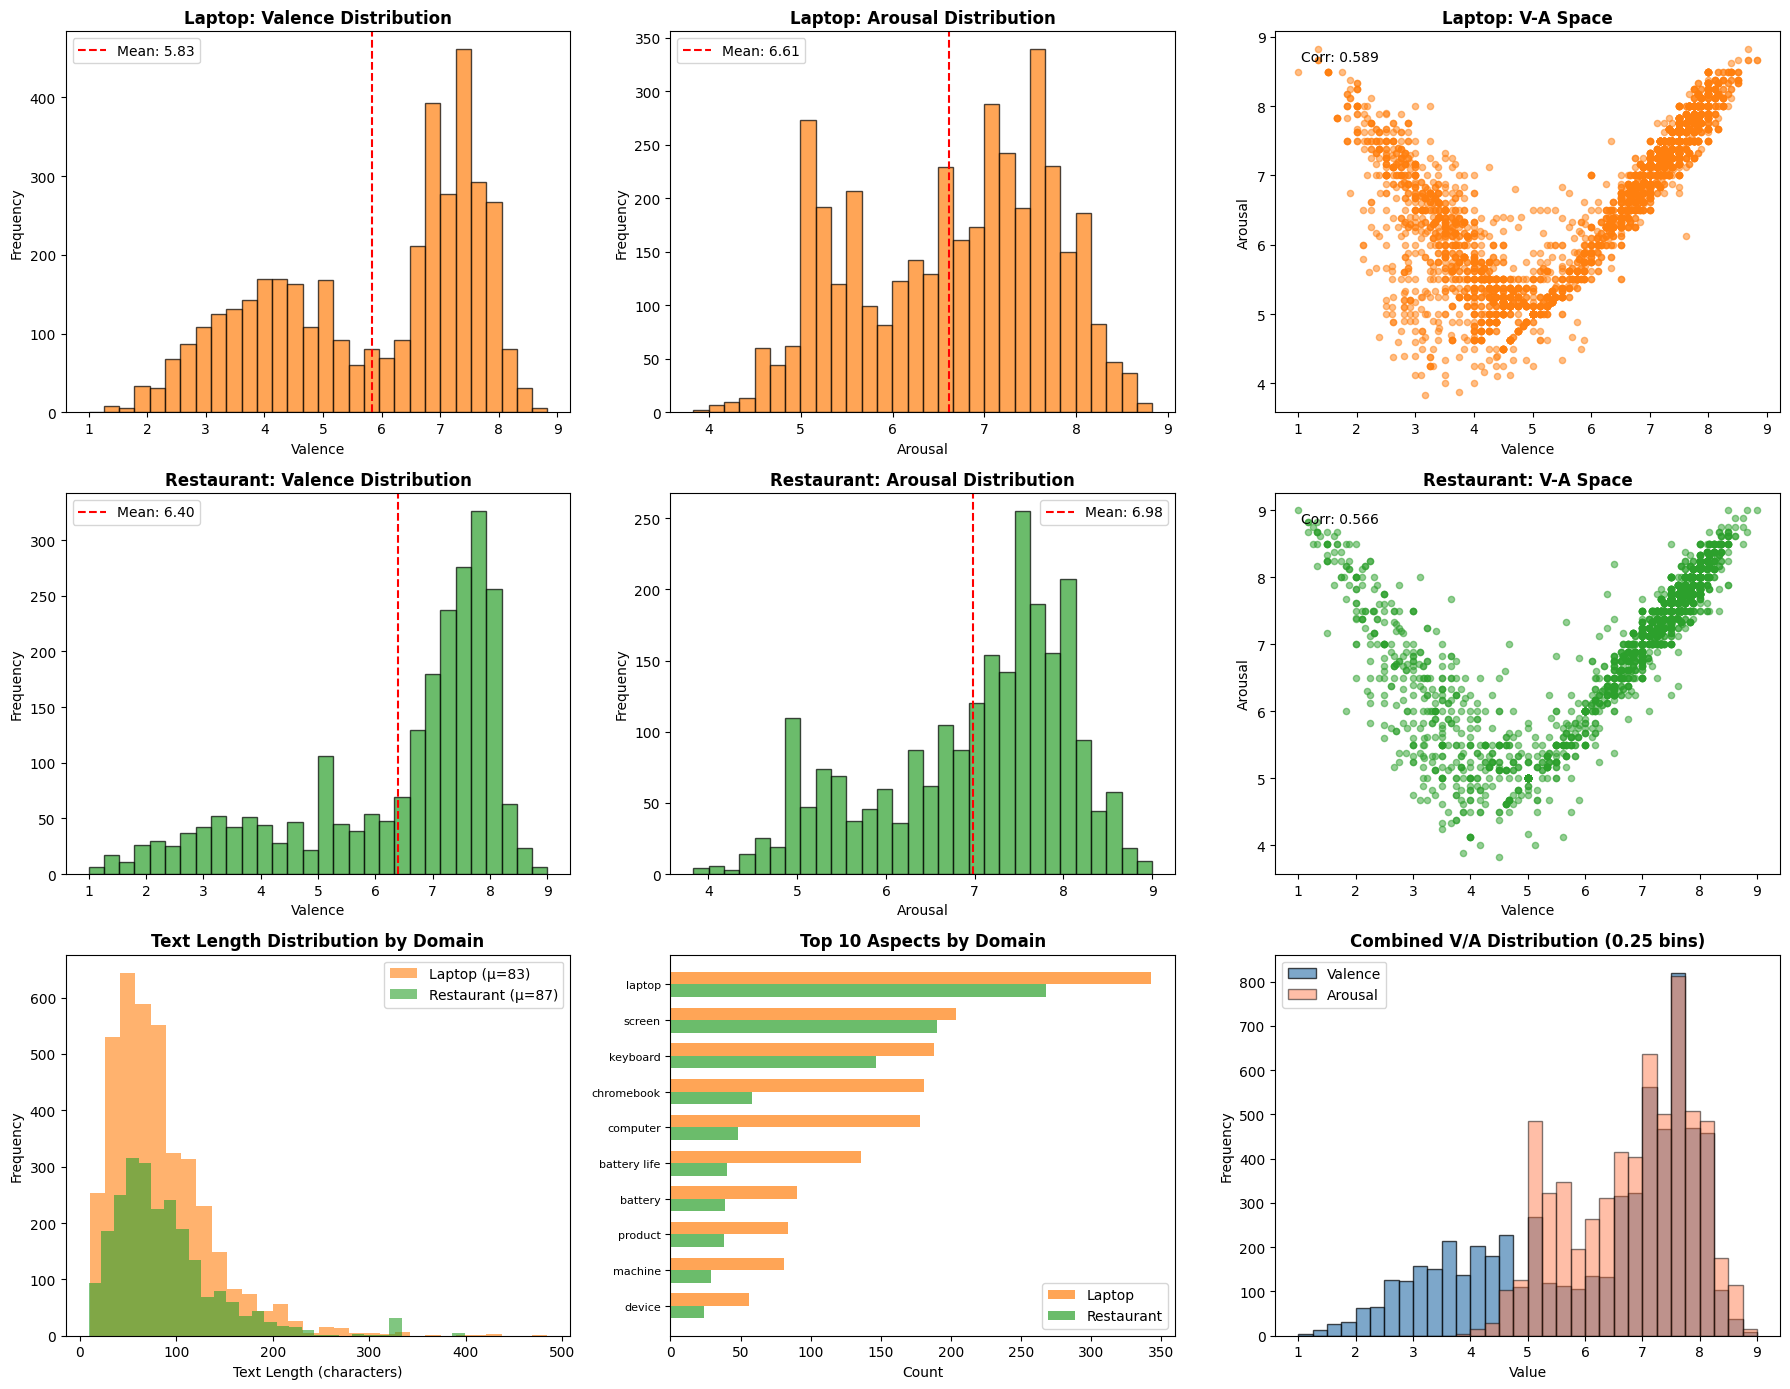


Distribution plots saved as 'eda_distributions.png'

V-A QUADRANT ANALYSIS

LAPTOP:
----------------------------------------
  High V, High A (excited/happy):  2566 (65.3%)
  High V, Low A (calm/content):      13 (0.3%)
  Low V, High A (angry/anxious):   1166 (29.7%)
  Low V, Low A (sad/bored):         185 (4.7%)

RESTAURANT:
----------------------------------------
  High V, High A (excited/happy):  1843 (78.9%)
  High V, Low A (calm/content):      14 (0.6%)
  Low V, High A (angry/anxious):    414 (17.7%)
  Low V, Low A (sad/bored):          66 (2.8%)

COMBINED:
----------------------------------------
  High V, High A (excited/happy):  4409 (70.4%)
  High V, Low A (calm/content):      27 (0.4%)
  Low V, High A (angry/anxious):   1580 (25.2%)
  Low V, Low A (sad/bored):         251 (4.0%)


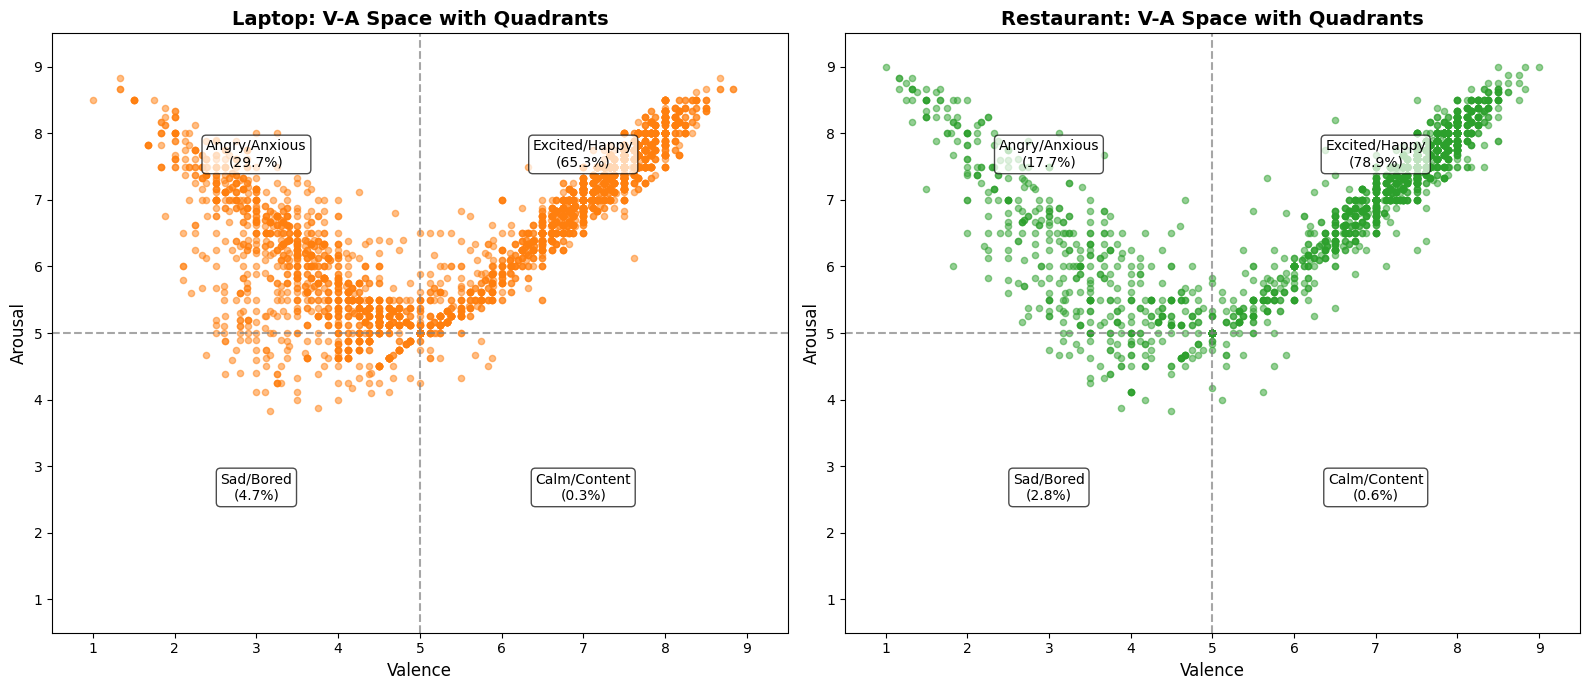


Quadrant plots saved as 'va_quadrants.png'

SAMPLE EXAMPLES FROM LAPTOP DATASET

--- High Valence, High Arousal (Excited/Happy) ---
  Text: i am very happy with this item ....
  Aspect: item
  V=7.4, A=7.5

  Text: after the ssd upgrade , the computer is very fast ....
  Aspect: computer
  V=7.2, A=7.2


--- High Valence, Low Arousal (Calm/Content) ---

--- Low Valence, High Arousal (Angry/Anxious) ---
  Text: battery doesn ' t last nearly as long as advertised ....
  Aspect: battery
  V=3.0, A=6.7

  Text: one of the keys is especially flimsy and feels like it could break at any moment...
  Aspect: one of the keys
  V=2.8, A=7.6


--- Low Valence, Low Arousal (Sad/Bored) ---

SAMPLE EXAMPLES FROM RESTAURANT DATASET

--- High Valence, High Arousal (Excited/Happy) ---
  Text: we ate out in the back patio , which is worth it as it ' s cool and the music is...
  Aspect: music
  V=7.6, A=7.5

  Text: simply some good tasting chinese food at incredible prices . . ....
  Aspect: chinese foo

In [ ]:
# ===========================================================================
# EDA HELPER FUNCTION
# ===========================================================================
def show_samples(df, condition, name, n=3):
    """Display sample examples matching a condition"""
    samples = df[condition].head(n)
    print(f"\n--- {name} ---")
    for _, row in samples.iterrows():
        print(f"  Text: {row['Text'][:80]}...")
        print(f"  Aspect: {row['Aspect']}")
        print(f"  V={row['Valence']:.1f}, A={row['Arousal']:.1f}")
        print()

# ===========================================================================
# ANALYZE LAPTOP DATASET
# ===========================================================================
print("\n" + "="*80)
print("LAPTOP DATASET ANALYSIS")
print("="*80)

laptop_full = pd.concat([laptop_train, laptop_val], ignore_index=True)

print(f"Total samples: {len(laptop_full)}")
print(f"Training samples: {len(laptop_train)}")
print(f"Validation samples: {len(laptop_val)}")
print(f"\nUnique texts: {laptop_full['Text'].nunique()}")
print(f"Unique aspects: {laptop_full['Aspect'].nunique()}")
print(f"\nValence range: [{laptop_full['Valence'].min():.2f}, {laptop_full['Valence'].max():.2f}]")
print(f"Arousal range: [{laptop_full['Arousal'].min():.2f}, {laptop_full['Arousal'].max():.2f}]")
print(f"Valence mean: {laptop_full['Valence'].mean():.2f} ± {laptop_full['Valence'].std():.2f}")
print(f"Arousal mean: {laptop_full['Arousal'].mean():.2f} ± {laptop_full['Arousal'].std():.2f}")

# ===========================================================================
# ANALYZE RESTAURANT DATASET
# ===========================================================================
print("\n" + "="*80)
print("RESTAURANT DATASET ANALYSIS")
print("="*80)

restaurant_full = pd.concat([restaurant_train, restaurant_val], ignore_index=True)

print(f"Total samples: {len(restaurant_full)}")
print(f"Training samples: {len(restaurant_train)}")
print(f"Validation samples: {len(restaurant_val)}")
print(f"\nUnique texts: {restaurant_full['Text'].nunique()}")
print(f"Unique aspects: {restaurant_full['Aspect'].nunique()}")
print(f"\nValence range: [{restaurant_full['Valence'].min():.2f}, {restaurant_full['Valence'].max():.2f}]")
print(f"Arousal range: [{restaurant_full['Arousal'].min():.2f}, {restaurant_full['Arousal'].max():.2f}]")
print(f"Valence mean: {restaurant_full['Valence'].mean():.2f} ± {restaurant_full['Valence'].std():.2f}")
print(f"Arousal mean: {restaurant_full['Arousal'].mean():.2f} ± {restaurant_full['Arousal'].std():.2f}")

# ===========================================================================
# COMBINED DATASET OVERVIEW
# ===========================================================================
print("\n" + "="*80)
print("COMBINED DATASET OVERVIEW")
print("="*80)

combined_full = pd.concat([combined_train, combined_val], ignore_index=True)

print(f"Total samples: {len(combined_full)}")
print(f"  Laptop: {len(laptop_full)} ({100*len(laptop_full)/len(combined_full):.1f}%)")
print(f"  Restaurant: {len(restaurant_full)} ({100*len(restaurant_full)/len(combined_full):.1f}%)")

# ===========================================================================
# DISTRIBUTION PLOTS
# ===========================================================================
print("\n" + "="*80)
print("GENERATING DISTRIBUTION PLOTS")
print("="*80)

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

# ROW 1: LAPTOP DISTRIBUTIONS
# Laptop Valence
ax = axes[0, 0]
ax.hist(laptop_full['Valence'], bins=30, edgecolor='black', alpha=0.7, color='#ff7f0e')
ax.axvline(laptop_full['Valence'].mean(), color='red', linestyle='--',
          label=f'Mean: {laptop_full["Valence"].mean():.2f}')
ax.set_xlabel('Valence')
ax.set_ylabel('Frequency')
ax.set_title('Laptop: Valence Distribution', fontweight='bold')
ax.legend()

# Laptop Arousal
ax = axes[0, 1]
ax.hist(laptop_full['Arousal'], bins=30, edgecolor='black', alpha=0.7, color='#ff7f0e')
ax.axvline(laptop_full['Arousal'].mean(), color='red', linestyle='--',
          label=f'Mean: {laptop_full["Arousal"].mean():.2f}')
ax.set_xlabel('Arousal')
ax.set_ylabel('Frequency')
ax.set_title('Laptop: Arousal Distribution', fontweight='bold')
ax.legend()

# Laptop V-A Scatter
ax = axes[0, 2]
ax.scatter(laptop_full['Valence'], laptop_full['Arousal'], alpha=0.5, color='#ff7f0e', s=20)
ax.set_xlabel('Valence')
ax.set_ylabel('Arousal')
ax.set_title('Laptop: V-A Space', fontweight='bold')
corr_laptop = laptop_full['Valence'].corr(laptop_full['Arousal'])
ax.text(0.05, 0.95, f'Corr: {corr_laptop:.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

# ROW 2: RESTAURANT DISTRIBUTIONS
# Restaurant Valence
ax = axes[1, 0]
ax.hist(restaurant_full['Valence'], bins=30, edgecolor='black', alpha=0.7, color='#2ca02c')
ax.axvline(restaurant_full['Valence'].mean(), color='red', linestyle='--',
          label=f'Mean: {restaurant_full["Valence"].mean():.2f}')
ax.set_xlabel('Valence')
ax.set_ylabel('Frequency')
ax.set_title('Restaurant: Valence Distribution', fontweight='bold')
ax.legend()

# Restaurant Arousal
ax = axes[1, 1]
ax.hist(restaurant_full['Arousal'], bins=30, edgecolor='black', alpha=0.7, color='#2ca02c')
ax.axvline(restaurant_full['Arousal'].mean(), color='red', linestyle='--',
          label=f'Mean: {restaurant_full["Arousal"].mean():.2f}')
ax.set_xlabel('Arousal')
ax.set_ylabel('Frequency')
ax.set_title('Restaurant: Arousal Distribution', fontweight='bold')
ax.legend()

# Restaurant V-A Scatter
ax = axes[1, 2]
ax.scatter(restaurant_full['Valence'], restaurant_full['Arousal'], alpha=0.5, color='#2ca02c', s=20)
ax.set_xlabel('Valence')
ax.set_ylabel('Arousal')
ax.set_title('Restaurant: V-A Space', fontweight='bold')
corr_restaurant = restaurant_full['Valence'].corr(restaurant_full['Arousal'])
ax.text(0.05, 0.95, f'Corr: {corr_restaurant:.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

# ROW 3: COMBINED ANALYSIS
# Text Length Distribution
ax = axes[2, 0]
laptop_lengths = laptop_full['Text'].str.len()
restaurant_lengths = restaurant_full['Text'].str.len()
ax.hist(laptop_lengths, bins=30, alpha=0.6, color='#ff7f0e', label=f'Laptop (μ={laptop_lengths.mean():.0f})')
ax.hist(restaurant_lengths, bins=30, alpha=0.6, color='#2ca02c', label=f'Restaurant (μ={restaurant_lengths.mean():.0f})')
ax.set_xlabel('Text Length (characters)')
ax.set_ylabel('Frequency')
ax.set_title('Text Length Distribution by Domain', fontweight='bold')
ax.legend()

# Top Aspects Comparison
ax = axes[2, 1]
laptop_aspects = laptop_full['Aspect'].value_counts()
restaurant_aspects = restaurant_full['Aspect'].value_counts()

# Get union of top 10 aspects from both domains
all_aspects = set(laptop_aspects.head(10).index) | set(restaurant_aspects.head(10).index)
# Sort by combined count (laptop + restaurant) to get top 10
combined_counts = pd.Series({
    aspect: laptop_aspects.get(aspect, 0) + restaurant_aspects.get(aspect, 0)
    for aspect in all_aspects
}).sort_values(ascending=False).head(10)

# Get counts for each domain for the top aspects
laptop_counts = [laptop_aspects.get(aspect, 0) for aspect in combined_counts.index]
restaurant_counts = [restaurant_aspects.get(aspect, 0) for aspect in combined_counts.index]

y_pos = np.arange(len(combined_counts))
width = 0.35
ax.barh(y_pos - width/2, laptop_counts, width, label='Laptop', color='#ff7f0e', alpha=0.7)
ax.barh(y_pos + width/2, restaurant_counts, width, label='Restaurant', color='#2ca02c', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(combined_counts.index, fontsize=8)
ax.set_xlabel('Count')
ax.set_title('Top 10 Aspects by Domain', fontweight='bold')
ax.legend()
ax.invert_yaxis()

# V-A Binned Distribution
ax = axes[2, 2]
bins_025 = np.arange(1, 9.25, 0.25)
ax.hist(combined_full['Valence'], bins=bins_025, alpha=0.7, color='steelblue', label='Valence', edgecolor='black')
ax.hist(combined_full['Arousal'], bins=bins_025, alpha=0.5, color='coral', label='Arousal', edgecolor='black')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Combined V/A Distribution (0.25 bins)', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDistribution plots saved as 'eda_distributions.png'")

# ===========================================================================
# V-A QUADRANT ANALYSIS
# ===========================================================================
print("\n" + "="*80)
print("V-A QUADRANT ANALYSIS")
print("="*80)

v_mid = 5.0
a_mid = 5.0

for domain_name, domain_df in [("LAPTOP", laptop_full), ("RESTAURANT", restaurant_full), ("COMBINED", combined_full)]:
    print(f"\n{domain_name}:")
    print("-" * 40)

    high_v_high_a = ((domain_df['Valence'] >= v_mid) & (domain_df['Arousal'] >= a_mid)).sum()
    high_v_low_a = ((domain_df['Valence'] >= v_mid) & (domain_df['Arousal'] < a_mid)).sum()
    low_v_high_a = ((domain_df['Valence'] < v_mid) & (domain_df['Arousal'] >= a_mid)).sum()
    low_v_low_a = ((domain_df['Valence'] < v_mid) & (domain_df['Arousal'] < a_mid)).sum()

    total = len(domain_df)
    print(f"  High V, High A (excited/happy):  {high_v_high_a:4d} ({100*high_v_high_a/total:.1f}%)")
    print(f"  High V, Low A (calm/content):    {high_v_low_a:4d} ({100*high_v_low_a/total:.1f}%)")
    print(f"  Low V, High A (angry/anxious):   {low_v_high_a:4d} ({100*low_v_high_a/total:.1f}%)")
    print(f"  Low V, Low A (sad/bored):        {low_v_low_a:4d} ({100*low_v_low_a/total:.1f}%)")

# Visualize quadrants for both domains
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, (domain_name, domain_df, color) in enumerate([
    ("Laptop", laptop_full, '#ff7f0e'),
    ("Restaurant", restaurant_full, '#2ca02c')
]):
    ax = axes[idx]

    # Scatter plot
    ax.scatter(domain_df['Valence'], domain_df['Arousal'], alpha=0.5, c=color, s=20)
    ax.axhline(y=a_mid, color='gray', linestyle='--', alpha=0.7)
    ax.axvline(x=v_mid, color='gray', linestyle='--', alpha=0.7)
    ax.set_xlabel('Valence', fontsize=12)
    ax.set_ylabel('Arousal', fontsize=12)
    ax.set_title(f'{domain_name}: V-A Space with Quadrants', fontsize=14, fontweight='bold')
    ax.set_xlim(0.5, 9.5)
    ax.set_ylim(0.5, 9.5)

    # Calculate quadrant percentages
    high_v_high_a = ((domain_df['Valence'] >= v_mid) & (domain_df['Arousal'] >= a_mid)).sum()
    high_v_low_a = ((domain_df['Valence'] >= v_mid) & (domain_df['Arousal'] < a_mid)).sum()
    low_v_high_a = ((domain_df['Valence'] < v_mid) & (domain_df['Arousal'] >= a_mid)).sum()
    low_v_low_a = ((domain_df['Valence'] < v_mid) & (domain_df['Arousal'] < a_mid)).sum()
    total = len(domain_df)

    # Add quadrant labels
    ax.text(7, 7.5, f'Excited/Happy\n({100*high_v_high_a/total:.1f}%)', fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax.text(7, 2.5, f'Calm/Content\n({100*high_v_low_a/total:.1f}%)', fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax.text(3, 7.5, f'Angry/Anxious\n({100*low_v_high_a/total:.1f}%)', fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax.text(3, 2.5, f'Sad/Bored\n({100*low_v_low_a/total:.1f}%)', fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('va_quadrants.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nQuadrant plots saved as 'va_quadrants.png'")

# ===========================================================================
# SAMPLE EXAMPLES FROM EACH QUADRANT
# ===========================================================================
print("\n" + "="*80)
print("SAMPLE EXAMPLES FROM LAPTOP DATASET")
print("="*80)

show_samples(laptop_full, (laptop_full['Valence'] >= 7) & (laptop_full['Arousal'] >= 6),
            "High Valence, High Arousal (Excited/Happy)", n=2)
show_samples(laptop_full, (laptop_full['Valence'] >= 7) & (laptop_full['Arousal'] <= 4),
            "High Valence, Low Arousal (Calm/Content)", n=2)
show_samples(laptop_full, (laptop_full['Valence'] <= 3) & (laptop_full['Arousal'] >= 6),
            "Low Valence, High Arousal (Angry/Anxious)", n=2)
show_samples(laptop_full, (laptop_full['Valence'] <= 3) & (laptop_full['Arousal'] <= 4),
            "Low Valence, Low Arousal (Sad/Bored)", n=2)

print("\n" + "="*80)
print("SAMPLE EXAMPLES FROM RESTAURANT DATASET")
print("="*80)

show_samples(restaurant_full, (restaurant_full['Valence'] >= 7) & (restaurant_full['Arousal'] >= 6),
            "High Valence, High Arousal (Excited/Happy)", n=2)
show_samples(restaurant_full, (restaurant_full['Valence'] >= 7) & (restaurant_full['Arousal'] <= 4),
            "High Valence, Low Arousal (Calm/Content)", n=2)
show_samples(restaurant_full, (restaurant_full['Valence'] <= 3) & (restaurant_full['Arousal'] >= 6),
            "Low Valence, High Arousal (Angry/Anxious)", n=2)
show_samples(restaurant_full, (restaurant_full['Valence'] <= 3) & (restaurant_full['Arousal'] <= 4),
            "Low Valence, Low Arousal (Sad/Bored)", n=2)

print("\n" + "="*80)
print("EDA COMPLETED")
print("="*80)

## Cell 5: Dataset Class with Domain Flag Support

In [6]:
class DimABSADataset(Dataset):
    """Dataset with optional domain flag as special token"""

    def __init__(self, dataframe: pd.DataFrame, tokenizer, max_len: int = 256,
                 use_domain_flag: bool = True):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.use_domain_flag = use_domain_flag

        self.texts = dataframe["Text"].tolist()
        self.aspects = dataframe["Aspect"].tolist()
        self.valences = dataframe["Valence"].values.astype(float)
        self.arousals = dataframe["Arousal"].values.astype(float)
        self.domains = dataframe["domain"].tolist() if "domain" in dataframe else None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        aspect = self.aspects[idx]

        # Format with domain flag: [DOMAIN] text [SEP] aspect
        if self.use_domain_flag and self.domains:
            domain_tag = f"[{self.domains[idx].upper()}]"
            input_text = f"{domain_tag} {text} [SEP] {aspect}"
        else:
            input_text = f"{text} [SEP] {aspect}"

        # Tokenize
        encoded = self.tokenizer(
            input_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": torch.tensor([self.valences[idx], self.arousals[idx]], dtype=torch.float)
        }

print("DimABSADataset class defined successfully!")

# Test dataset formatting
print("\nExample input formatting:")
sample_text = "The keyboard is excellent and very responsive"
sample_aspect = "keyboard"
print(f"  Without domain flag: {sample_text} [SEP] {sample_aspect}")
print(f"  With domain flag:    [LAPTOP] {sample_text} [SEP] {sample_aspect}")

DimABSADataset class defined successfully!

Example input formatting:
  Without domain flag: The keyboard is excellent and very responsive [SEP] keyboard
  With domain flag:    [LAPTOP] The keyboard is excellent and very responsive [SEP] keyboard


## Cell 6: Model Architecture

In [7]:
class SimpleRegressor(nn.Module):
    """Simple [CLS] -> Linear regression head for V/A prediction"""

    def __init__(self, model_name: str, dropout: float = 0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(hidden_size, 2)  # Output: [Valence, Arousal]

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        x = self.dropout(cls_output)
        return self.regressor(x)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

print("SimpleRegressor model architecture defined successfully!")

SimpleRegressor model architecture defined successfully!


## Cell 7: RMSE Calculation

In [8]:
def compute_metrics(preds: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
    """
    Compute RMSE and Pearson correlation matching OFFICIAL DimABSA evaluation script.

    Official RMSE formula (from evaluate.py):
        RMSE_VA = sqrt( sum((V_p - V_g)^2 + (A_p - A_g)^2) / N )

    Where N = number of samples (not 2*N)
    Normalized: RMSE_VA / sqrt(128)

    This matches the evaluate_predictions_task1() function in the official script.
    """
    pred_v, pred_a = preds[:, 0], preds[:, 1]
    gold_v, gold_a = labels[:, 0], labels[:, 1]
    n_samples = len(pred_v)

    # Official formula: sum of squared V errors + sum of squared A errors, divided by N
    v_squared_errors = (pred_v - gold_v) ** 2
    a_squared_errors = (pred_a - gold_a) ** 2

    # RMSE = sqrt( (sum(v_errors^2) + sum(a_errors^2)) / N )
    rmse = np.sqrt((np.sum(v_squared_errors) + np.sum(a_squared_errors)) / n_samples)

    # Normalized RMSE (divide by sqrt(128) = max distance in [1,9]x[1,9] space)
    rmse_norm = rmse / np.sqrt(128)

    # Pearson correlation (same as official)
    pcc_v = pearsonr(pred_v, gold_v)[0]
    pcc_a = pearsonr(pred_a, gold_a)[0]

    return {
        "rmse": rmse,           # Raw RMSE (official without normalization)
        "rmse_norm": rmse_norm, # Normalized RMSE (official with --do_norm)
        "pcc_v": pcc_v,
        "pcc_a": pcc_a
    }

print("Official RMSE calculation function defined successfully!")
print("Formula: RMSE = sqrt((sum(V_errors^2) + sum(A_errors^2)) / N)")
print("Normalized: RMSE / sqrt(128)")

Official RMSE calculation function defined successfully!
Formula: RMSE = sqrt((sum(V_errors^2) + sum(A_errors^2)) / N)
Normalized: RMSE / sqrt(128)


## Cell 8: Training Function with Early Stopping

In [11]:
def train_model(model, train_loader, val_loader, optimizer, scheduler,
                loss_fn, device, epochs=5, patience=3):
    """Train model with early stopping based on validation RMSE"""
    best_rmse = float('inf')
    best_model_state = None
    patience_counter = 0
    history = {
        'train_loss': [],
        'val_rmse': [],
        'val_pcc_v': [],
        'val_pcc_a': []
    }

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask)
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        preds = np.vstack(all_preds)
        labels_np = np.vstack(all_labels)
        metrics = compute_metrics(preds, labels_np)

        history['train_loss'].append(train_loss)
        history['val_rmse'].append(metrics['rmse'])
        history['val_pcc_v'].append(metrics['pcc_v'])
        history['val_pcc_a'].append(metrics['pcc_a'])

        print(f"Epoch {epoch}/{epochs} | "
              f"Loss: {train_loss:.4f} | "
              f"RMSE: {metrics['rmse']:.4f} | "
              f"RMSE_norm: {metrics['rmse_norm']:.4f} | "
              f"PCC_V: {metrics['pcc_v']:.4f} | "
              f"PCC_A: {metrics['pcc_a']:.4f}")

        # Early stopping
        if metrics['rmse'] < best_rmse:
            best_rmse = metrics['rmse']
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            print(f"  -> New best model! RMSE: {best_rmse:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  -> Early stopping at epoch {epoch}")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"\nRestored best model with RMSE: {best_rmse:.4f}")

    return model, best_rmse, history

print("Training function with early stopping defined successfully!")

Training function with early stopping defined successfully!


## Cell 9: Hyperparameter Search Grid

We'll test 3 different configurations for each model-domain combination:
- **Config 1**: lr=2e-5, batch_size=16, epochs=5 (balanced)
- **Config 2**: lr=1e-5, batch_size=8, epochs=7 (conservative, more epochs)
- **Config 3**: lr=3e-5, batch_size=32, epochs=3 (aggressive, larger batches)

In [12]:
# Define hyperparameter configurations
HP_CONFIGS = [
    {'lr': 2e-5, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1},  # Config 1
    {'lr': 1e-5, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1},   # Config 2
    {'lr': 3e-5, 'batch_size': 32, 'epochs': 3, 'dropout': 0.2}   # Config 3
]

print("Hyperparameter Configurations:")
print("="*60)
for i, cfg in enumerate(HP_CONFIGS, 1):
    print(f"Config {i}: LR={cfg['lr']}, Batch={cfg['batch_size']}, "
          f"Epochs={cfg['epochs']}, Dropout={cfg['dropout']}")
print("="*60)

Hyperparameter Configurations:
Config 1: LR=2e-05, Batch=16, Epochs=5, Dropout=0.1
Config 2: LR=1e-05, Batch=8, Epochs=7, Dropout=0.1
Config 3: LR=3e-05, Batch=32, Epochs=3, Dropout=0.2


## Cell 10: Training - Combined Dataset Model (BERT and RoBERTa)

Train both BERT-base and RoBERTa-base on combined laptop+restaurant data.

In [27]:
# ===========================================================================
# HYPERPARAM TUNING ON EACH DOMAIN (TRAIN ON COMBINED)
# ===========================================================================

def tune_on_domain(model_name, tokenizer, domain_name, val_df):
    print("" + "="*60)
    print(f"TUNING {model_name.upper()} ON {domain_name.upper()} VALIDATION")
    print("="*60)

    best_rmse = float('inf')
    best_model = None
    best_config = None
    best_history = None

    for i, cfg in enumerate(HP_CONFIGS, 1):
        print(f"Config {i}: {cfg}")

        train_dataset = DimABSADataset(combined_train, tokenizer, use_domain_flag=True)
        val_dataset = DimABSADataset(val_df, tokenizer, use_domain_flag=True)

        train_loader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=cfg['batch_size'], shuffle=False)

        model = SimpleRegressor(model_name, dropout=cfg['dropout']).to(DEVICE)
        print(f"Model parameters: {model.count_parameters():,}")

        optimizer = AdamW(model.parameters(), lr=cfg['lr'], weight_decay=0.01)
        total_steps = len(train_loader) * cfg['epochs']
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            int(0.1 * total_steps),
            total_steps
        )

        model, rmse, history = train_model(
            model,
            train_loader,
            val_loader,
            optimizer,
            scheduler,
            nn.MSELoss(),
            DEVICE,
            epochs=cfg['epochs'],
            patience=3
        )

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_config = cfg
            best_history = history
            print(f"  -> New best for {domain_name}: RMSE {best_rmse:.4f}")

    print("" + "-"*60)
    print(f"BEST {model_name.upper()} on {domain_name}: RMSE {best_rmse:.4f}")
    print(f"Best config: {best_config}")
    print("-"*60)
    return best_model, best_rmse, best_config, best_history

# ===========================================================================
# BERT-BASE: TUNE PER DOMAIN, TRAIN ON COMBINED
# ===========================================================================
print("" + "="*60)
print("BERT-BASE: TRAIN ON COMBINED, TUNE PER DOMAIN")
print("="*60)

tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

best_bert_laptop, best_rmse_bert_laptop, best_cfg_bert_laptop, _ = tune_on_domain(
    "bert-base-uncased",
    tokenizer_bert,
    "laptop",
    laptop_val
)

best_bert_restaurant, best_rmse_bert_restaurant, best_cfg_bert_restaurant, _ = tune_on_domain(
    "bert-base-uncased",
    tokenizer_bert,
    "restaurant",
    restaurant_val
)

# Save BERT models
torch.save(best_bert_laptop.state_dict(), "combined_bert_laptop.pt")
torch.save(best_bert_restaurant.state_dict(), "combined_bert_restaurant.pt")
print("Saved: combined_bert_laptop.pt, combined_bert_restaurant.pt")

# ===========================================================================
# ROBERTA-BASE: TUNE PER DOMAIN, TRAIN ON COMBINED
# ===========================================================================
print("" + "="*60)
print("ROBERTA-BASE: TRAIN ON COMBINED, TUNE PER DOMAIN")
print("="*60)

tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")

best_roberta_laptop, best_rmse_roberta_laptop, best_cfg_roberta_laptop, _ = tune_on_domain(
    "roberta-base",
    tokenizer_roberta,
    "laptop",
    laptop_val
)

best_roberta_restaurant, best_rmse_roberta_restaurant, best_cfg_roberta_restaurant, _ = tune_on_domain(
    "roberta-base",
    tokenizer_roberta,
    "restaurant",
    restaurant_val
)

# Save RoBERTa models
torch.save(best_roberta_laptop.state_dict(), "combined_roberta_laptop.pt")
torch.save(best_roberta_restaurant.state_dict(), "combined_roberta_restaurant.pt")
print("Saved: combined_roberta_laptop.pt, combined_roberta_restaurant.pt")


BERT-BASE: TRAIN ON COMBINED, TUNE PER DOMAIN
TUNING BERT-BASE-UNCASED ON LAPTOP VALIDATION
Config 1: {'lr': 2e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 6.3862 | RMSE: 1.3213 | RMSE_norm: 0.1168 | PCC_V: 0.8686 | PCC_A: 0.6644
  -> New best model! RMSE: 1.3213


Epoch 2:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 2/5 | Loss: 0.6542 | RMSE: 1.1523 | RMSE_norm: 0.1019 | PCC_V: 0.8958 | PCC_A: 0.7187
  -> New best model! RMSE: 1.1523


Epoch 3:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 3/5 | Loss: 0.4260 | RMSE: 1.0999 | RMSE_norm: 0.0972 | PCC_V: 0.9060 | PCC_A: 0.7356
  -> New best model! RMSE: 1.0999


Epoch 4:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 4/5 | Loss: 0.3152 | RMSE: 1.1754 | RMSE_norm: 0.1039 | PCC_V: 0.8966 | PCC_A: 0.7262


Epoch 5:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 5/5 | Loss: 0.2541 | RMSE: 1.1627 | RMSE_norm: 0.1028 | PCC_V: 0.8987 | PCC_A: 0.7285

Restored best model with RMSE: 1.0999
  -> New best for laptop: RMSE 1.0999
Config 2: {'lr': 1e-05, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 1/7 | Loss: 7.7877 | RMSE: 1.2907 | RMSE_norm: 0.1141 | PCC_V: 0.8763 | PCC_A: 0.6401
  -> New best model! RMSE: 1.2907


Epoch 2:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 2/7 | Loss: 0.7109 | RMSE: 1.2150 | RMSE_norm: 0.1074 | PCC_V: 0.9038 | PCC_A: 0.7160
  -> New best model! RMSE: 1.2150


Epoch 3:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 3/7 | Loss: 0.4926 | RMSE: 1.1896 | RMSE_norm: 0.1052 | PCC_V: 0.9033 | PCC_A: 0.7097
  -> New best model! RMSE: 1.1896


Epoch 4:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 4/7 | Loss: 0.3677 | RMSE: 1.2452 | RMSE_norm: 0.1101 | PCC_V: 0.9015 | PCC_A: 0.7147


Epoch 5:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 5/7 | Loss: 0.3014 | RMSE: 1.2050 | RMSE_norm: 0.1065 | PCC_V: 0.8969 | PCC_A: 0.7151


Epoch 6:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 6/7 | Loss: 0.2545 | RMSE: 1.1754 | RMSE_norm: 0.1039 | PCC_V: 0.9006 | PCC_A: 0.7140
  -> New best model! RMSE: 1.1754


Epoch 7:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 7/7 | Loss: 0.2249 | RMSE: 1.1818 | RMSE_norm: 0.1045 | PCC_V: 0.9007 | PCC_A: 0.7133

Restored best model with RMSE: 1.1754
Config 3: {'lr': 3e-05, 'batch_size': 32, 'epochs': 3, 'dropout': 0.2}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/3 | Loss: 5.5812 | RMSE: 1.1825 | RMSE_norm: 0.1045 | PCC_V: 0.8814 | PCC_A: 0.6887
  -> New best model! RMSE: 1.1825


Epoch 2:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/3 | Loss: 0.6805 | RMSE: 1.1636 | RMSE_norm: 0.1028 | PCC_V: 0.8930 | PCC_A: 0.7003
  -> New best model! RMSE: 1.1636


Epoch 3:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/3 | Loss: 0.4717 | RMSE: 1.1737 | RMSE_norm: 0.1037 | PCC_V: 0.8943 | PCC_A: 0.7041

Restored best model with RMSE: 1.1636
------------------------------------------------------------
BEST BERT-BASE-UNCASED on laptop: RMSE 1.0999
Best config: {'lr': 2e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1}
------------------------------------------------------------
TUNING BERT-BASE-UNCASED ON RESTAURANT VALIDATION
Config 1: {'lr': 2e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 6.5907 | RMSE: 1.4361 | RMSE_norm: 0.1269 | PCC_V: 0.7989 | PCC_A: 0.6046
  -> New best model! RMSE: 1.4361


Epoch 2:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 2/5 | Loss: 0.6357 | RMSE: 1.2197 | RMSE_norm: 0.1078 | PCC_V: 0.8794 | PCC_A: 0.7076
  -> New best model! RMSE: 1.2197


Epoch 3:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 3/5 | Loss: 0.4164 | RMSE: 1.2132 | RMSE_norm: 0.1072 | PCC_V: 0.8803 | PCC_A: 0.7290
  -> New best model! RMSE: 1.2132


Epoch 4:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 4/5 | Loss: 0.3125 | RMSE: 1.2236 | RMSE_norm: 0.1082 | PCC_V: 0.8859 | PCC_A: 0.7321


Epoch 5:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 5/5 | Loss: 0.2456 | RMSE: 1.2000 | RMSE_norm: 0.1061 | PCC_V: 0.8875 | PCC_A: 0.7331
  -> New best model! RMSE: 1.2000

Restored best model with RMSE: 1.2000
  -> New best for restaurant: RMSE 1.2000
Config 2: {'lr': 1e-05, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 1/7 | Loss: 7.1904 | RMSE: 1.4134 | RMSE_norm: 0.1249 | PCC_V: 0.8140 | PCC_A: 0.5836
  -> New best model! RMSE: 1.4134


Epoch 2:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 2/7 | Loss: 0.7102 | RMSE: 1.3350 | RMSE_norm: 0.1180 | PCC_V: 0.8641 | PCC_A: 0.6759
  -> New best model! RMSE: 1.3350


Epoch 3:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 3/7 | Loss: 0.4886 | RMSE: 1.1438 | RMSE_norm: 0.1011 | PCC_V: 0.8856 | PCC_A: 0.7417
  -> New best model! RMSE: 1.1438


Epoch 4:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 4/7 | Loss: 0.3704 | RMSE: 1.2331 | RMSE_norm: 0.1090 | PCC_V: 0.8810 | PCC_A: 0.7286


Epoch 5:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 5/7 | Loss: 0.2959 | RMSE: 1.2142 | RMSE_norm: 0.1073 | PCC_V: 0.8888 | PCC_A: 0.7331


Epoch 6:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 6/7 | Loss: 0.2479 | RMSE: 1.2143 | RMSE_norm: 0.1073 | PCC_V: 0.8841 | PCC_A: 0.7295
  -> Early stopping at epoch 6

Restored best model with RMSE: 1.1438
  -> New best for restaurant: RMSE 1.1438
Config 3: {'lr': 3e-05, 'batch_size': 32, 'epochs': 3, 'dropout': 0.2}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/3 | Loss: 5.5674 | RMSE: 1.3833 | RMSE_norm: 0.1223 | PCC_V: 0.8202 | PCC_A: 0.6264
  -> New best model! RMSE: 1.3833


Epoch 2:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/3 | Loss: 0.6672 | RMSE: 1.2390 | RMSE_norm: 0.1095 | PCC_V: 0.8651 | PCC_A: 0.7199
  -> New best model! RMSE: 1.2390


Epoch 3:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/3 | Loss: 0.4671 | RMSE: 1.2159 | RMSE_norm: 0.1075 | PCC_V: 0.8787 | PCC_A: 0.7254
  -> New best model! RMSE: 1.2159

Restored best model with RMSE: 1.2159
------------------------------------------------------------
BEST BERT-BASE-UNCASED on restaurant: RMSE 1.1438
Best config: {'lr': 1e-05, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1}
------------------------------------------------------------
Saved: combined_bert_laptop.pt, combined_bert_restaurant.pt
ROBERTA-BASE: TRAIN ON COMBINED, TUNE PER DOMAIN
TUNING ROBERTA-BASE ON LAPTOP VALIDATION
Config 1: {'lr': 2e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 7.2942 | RMSE: 1.2800 | RMSE_norm: 0.1131 | PCC_V: 0.8782 | PCC_A: 0.6865
  -> New best model! RMSE: 1.2800


Epoch 2:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 2/5 | Loss: 0.6592 | RMSE: 1.1574 | RMSE_norm: 0.1023 | PCC_V: 0.9066 | PCC_A: 0.7130
  -> New best model! RMSE: 1.1574


Epoch 3:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 3/5 | Loss: 0.4759 | RMSE: 1.1969 | RMSE_norm: 0.1058 | PCC_V: 0.9083 | PCC_A: 0.7191


Epoch 4:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 4/5 | Loss: 0.3673 | RMSE: 1.1434 | RMSE_norm: 0.1011 | PCC_V: 0.9082 | PCC_A: 0.7244
  -> New best model! RMSE: 1.1434


Epoch 5:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 5/5 | Loss: 0.3091 | RMSE: 1.1777 | RMSE_norm: 0.1041 | PCC_V: 0.9058 | PCC_A: 0.7225

Restored best model with RMSE: 1.1434
  -> New best for laptop: RMSE 1.1434
Config 2: {'lr': 1e-05, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 1/7 | Loss: 7.2383 | RMSE: 1.3602 | RMSE_norm: 0.1202 | PCC_V: 0.8635 | PCC_A: 0.6518
  -> New best model! RMSE: 1.3602


Epoch 2:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 2/7 | Loss: 0.6826 | RMSE: 1.2287 | RMSE_norm: 0.1086 | PCC_V: 0.8973 | PCC_A: 0.7076
  -> New best model! RMSE: 1.2287


Epoch 3:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 3/7 | Loss: 0.5032 | RMSE: 1.1528 | RMSE_norm: 0.1019 | PCC_V: 0.9079 | PCC_A: 0.7120
  -> New best model! RMSE: 1.1528


Epoch 4:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 4/7 | Loss: 0.4087 | RMSE: 1.1785 | RMSE_norm: 0.1042 | PCC_V: 0.9169 | PCC_A: 0.7122


Epoch 5:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 5/7 | Loss: 0.3348 | RMSE: 1.2220 | RMSE_norm: 0.1080 | PCC_V: 0.9121 | PCC_A: 0.7097


Epoch 6:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 6/7 | Loss: 0.2850 | RMSE: 1.2022 | RMSE_norm: 0.1063 | PCC_V: 0.9100 | PCC_A: 0.7016
  -> Early stopping at epoch 6

Restored best model with RMSE: 1.1528
Config 3: {'lr': 3e-05, 'batch_size': 32, 'epochs': 3, 'dropout': 0.2}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/3 | Loss: 6.9594 | RMSE: 1.2358 | RMSE_norm: 0.1092 | PCC_V: 0.8755 | PCC_A: 0.6750
  -> New best model! RMSE: 1.2358


Epoch 2:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/3 | Loss: 0.7046 | RMSE: 1.1506 | RMSE_norm: 0.1017 | PCC_V: 0.9004 | PCC_A: 0.6987
  -> New best model! RMSE: 1.1506


Epoch 3:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/3 | Loss: 0.4977 | RMSE: 1.1566 | RMSE_norm: 0.1022 | PCC_V: 0.9091 | PCC_A: 0.7157

Restored best model with RMSE: 1.1506
------------------------------------------------------------
BEST ROBERTA-BASE on laptop: RMSE 1.1434
Best config: {'lr': 2e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1}
------------------------------------------------------------
TUNING ROBERTA-BASE ON RESTAURANT VALIDATION
Config 1: {'lr': 2e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 7.2283 | RMSE: 1.6463 | RMSE_norm: 0.1455 | PCC_V: 0.8555 | PCC_A: 0.6399
  -> New best model! RMSE: 1.6463


Epoch 2:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 2/5 | Loss: 0.6128 | RMSE: 1.1861 | RMSE_norm: 0.1048 | PCC_V: 0.9131 | PCC_A: 0.7347
  -> New best model! RMSE: 1.1861


Epoch 3:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 3/5 | Loss: 0.4516 | RMSE: 1.2027 | RMSE_norm: 0.1063 | PCC_V: 0.8973 | PCC_A: 0.7305


Epoch 4:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 4/5 | Loss: 0.3535 | RMSE: 1.2270 | RMSE_norm: 0.1084 | PCC_V: 0.9094 | PCC_A: 0.7393


Epoch 5:   0%|          | 0/353 [00:00<?, ?it/s]

Epoch 5/5 | Loss: 0.2822 | RMSE: 1.2031 | RMSE_norm: 0.1063 | PCC_V: 0.9075 | PCC_A: 0.7414
  -> Early stopping at epoch 5

Restored best model with RMSE: 1.1861
  -> New best for restaurant: RMSE 1.1861
Config 2: {'lr': 1e-05, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 1/7 | Loss: 7.9222 | RMSE: 1.4372 | RMSE_norm: 0.1270 | PCC_V: 0.7974 | PCC_A: 0.5840
  -> New best model! RMSE: 1.4372


Epoch 2:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 2/7 | Loss: 0.7719 | RMSE: 1.3201 | RMSE_norm: 0.1167 | PCC_V: 0.8510 | PCC_A: 0.6810
  -> New best model! RMSE: 1.3201


Epoch 3:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 3/7 | Loss: 0.5516 | RMSE: 1.2656 | RMSE_norm: 0.1119 | PCC_V: 0.9001 | PCC_A: 0.7381
  -> New best model! RMSE: 1.2656


Epoch 4:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 4/7 | Loss: 0.4469 | RMSE: 1.1755 | RMSE_norm: 0.1039 | PCC_V: 0.9073 | PCC_A: 0.7227
  -> New best model! RMSE: 1.1755


Epoch 5:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 5/7 | Loss: 0.3688 | RMSE: 1.2128 | RMSE_norm: 0.1072 | PCC_V: 0.9134 | PCC_A: 0.7531


Epoch 6:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 6/7 | Loss: 0.3178 | RMSE: 1.1673 | RMSE_norm: 0.1032 | PCC_V: 0.9157 | PCC_A: 0.7469
  -> New best model! RMSE: 1.1673


Epoch 7:   0%|          | 0/705 [00:00<?, ?it/s]

Epoch 7/7 | Loss: 0.2829 | RMSE: 1.1455 | RMSE_norm: 0.1013 | PCC_V: 0.9140 | PCC_A: 0.7419
  -> New best model! RMSE: 1.1455

Restored best model with RMSE: 1.1455
  -> New best for restaurant: RMSE 1.1455
Config 3: {'lr': 3e-05, 'batch_size': 32, 'epochs': 3, 'dropout': 0.2}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/3 | Loss: 6.2637 | RMSE: 1.3913 | RMSE_norm: 0.1230 | PCC_V: 0.8431 | PCC_A: 0.6330
  -> New best model! RMSE: 1.3913


Epoch 2:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/3 | Loss: 0.7005 | RMSE: 1.2283 | RMSE_norm: 0.1086 | PCC_V: 0.8923 | PCC_A: 0.6929
  -> New best model! RMSE: 1.2283


Epoch 3:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/3 | Loss: 0.5052 | RMSE: 1.2055 | RMSE_norm: 0.1066 | PCC_V: 0.8978 | PCC_A: 0.7167
  -> New best model! RMSE: 1.2055

Restored best model with RMSE: 1.2055
------------------------------------------------------------
BEST ROBERTA-BASE on restaurant: RMSE 1.1455
Best config: {'lr': 1e-05, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1}
------------------------------------------------------------
Saved: combined_roberta_laptop.pt, combined_roberta_restaurant.pt


## Cell 11: Training - BERT on Laptop (3 Configs)

Train BERT-base separately on laptop data with 3 different hyperparameter configurations.

In [14]:
print("\n" + "="*60)
print("TRAINING BERT-BASE ON LAPTOP DATA (3 CONFIGS)")
print("="*60)

bert_laptop_results = []
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

for i, config in enumerate(HP_CONFIGS, 1):
    print(f"\n{'='*60}")
    print(f"Config {i}/{len(HP_CONFIGS)}: {config}")
    print(f"{'='*60}")
    set_seed(42)

    train_dataset = DimABSADataset(laptop_train, tokenizer_bert, use_domain_flag=False)
    val_dataset = DimABSADataset(laptop_val, tokenizer_bert, use_domain_flag=False)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    model = SimpleRegressor("bert-base-uncased", dropout=config['dropout']).to(DEVICE)
    print(f"Model parameters: {model.count_parameters():,}")

    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=0.01)
    total_steps = len(train_loader) * config['epochs']
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

    model, best_rmse, history = train_model(
        model, train_loader, val_loader, optimizer, scheduler,
        nn.MSELoss(), DEVICE, epochs=config['epochs'], patience=3
    )

    bert_laptop_results.append({
        'config': config,
        'model': model,
        'rmse': best_rmse,
        'history': history
    })
    print(f"\n*** Config {i} Final RMSE: {best_rmse:.4f} ***")

# Select best model
best_bert_laptop = min(bert_laptop_results, key=lambda x: x['rmse'])
print(f"\n{'='*60}")
print(f"BEST BERT-LAPTOP: Config with RMSE = {best_bert_laptop['rmse']:.4f}")
print(f"{'='*60}")


TRAINING BERT-BASE ON LAPTOP DATA (3 CONFIGS)

Config 1/3: {'lr': 2e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 8.6159 | RMSE: 1.3129 | RMSE_norm: 0.1160 | PCC_V: 0.8619 | PCC_A: 0.6302
  -> New best model! RMSE: 1.3129


Epoch 2:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Loss: 0.6613 | RMSE: 1.2280 | RMSE_norm: 0.1085 | PCC_V: 0.8770 | PCC_A: 0.6832
  -> New best model! RMSE: 1.2280


Epoch 3:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Loss: 0.4543 | RMSE: 1.1556 | RMSE_norm: 0.1021 | PCC_V: 0.8868 | PCC_A: 0.7112
  -> New best model! RMSE: 1.1556


Epoch 4:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Loss: 0.3371 | RMSE: 1.1927 | RMSE_norm: 0.1054 | PCC_V: 0.8839 | PCC_A: 0.7009


Epoch 5:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Loss: 0.2664 | RMSE: 1.2128 | RMSE_norm: 0.1072 | PCC_V: 0.8839 | PCC_A: 0.7016

Restored best model with RMSE: 1.1556

*** Config 1 Final RMSE: 1.1556 ***

Config 2/3: {'lr': 1e-05, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 1/7 | Loss: 9.7458 | RMSE: 1.3122 | RMSE_norm: 0.1160 | PCC_V: 0.8456 | PCC_A: 0.6105
  -> New best model! RMSE: 1.3122


Epoch 2:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 2/7 | Loss: 0.7217 | RMSE: 1.2191 | RMSE_norm: 0.1078 | PCC_V: 0.8804 | PCC_A: 0.6739
  -> New best model! RMSE: 1.2191


Epoch 3:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 3/7 | Loss: 0.5099 | RMSE: 1.1474 | RMSE_norm: 0.1014 | PCC_V: 0.8881 | PCC_A: 0.7143
  -> New best model! RMSE: 1.1474


Epoch 4:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 4/7 | Loss: 0.4062 | RMSE: 1.1766 | RMSE_norm: 0.1040 | PCC_V: 0.8913 | PCC_A: 0.7133


Epoch 5:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 5/7 | Loss: 0.3111 | RMSE: 1.1903 | RMSE_norm: 0.1052 | PCC_V: 0.8926 | PCC_A: 0.7121


Epoch 6:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 6/7 | Loss: 0.2655 | RMSE: 1.1747 | RMSE_norm: 0.1038 | PCC_V: 0.8916 | PCC_A: 0.7105
  -> Early stopping at epoch 6

Restored best model with RMSE: 1.1474

*** Config 2 Final RMSE: 1.1474 ***

Config 3/3: {'lr': 3e-05, 'batch_size': 32, 'epochs': 3, 'dropout': 0.2}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 1/3 | Loss: 8.3484 | RMSE: 1.3315 | RMSE_norm: 0.1177 | PCC_V: 0.8413 | PCC_A: 0.6146
  -> New best model! RMSE: 1.3315


Epoch 2:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 2/3 | Loss: 0.7123 | RMSE: 1.1754 | RMSE_norm: 0.1039 | PCC_V: 0.8768 | PCC_A: 0.6873
  -> New best model! RMSE: 1.1754


Epoch 3:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 3/3 | Loss: 0.5366 | RMSE: 1.1925 | RMSE_norm: 0.1054 | PCC_V: 0.8794 | PCC_A: 0.6958

Restored best model with RMSE: 1.1754

*** Config 3 Final RMSE: 1.1754 ***

BEST BERT-LAPTOP: Config with RMSE = 1.1474


## Cell 12: Training - BERT on Restaurant (3 Configs)

Train BERT-base separately on restaurant data with 3 different hyperparameter configurations.

In [15]:
print("\n" + "="*60)
print("TRAINING BERT-BASE ON RESTAURANT DATA (3 CONFIGS)")
print("="*60)

bert_restaurant_results = []
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

for i, config in enumerate(HP_CONFIGS, 1):
    print(f"\n{'='*60}")
    print(f"Config {i}/{len(HP_CONFIGS)}: {config}")
    print(f"{'='*60}")
    set_seed(42)

    train_dataset = DimABSADataset(restaurant_train, tokenizer_bert, use_domain_flag=False)
    val_dataset = DimABSADataset(restaurant_val, tokenizer_bert, use_domain_flag=False)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    model = SimpleRegressor("bert-base-uncased", dropout=config['dropout']).to(DEVICE)
    print(f"Model parameters: {model.count_parameters():,}")

    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=0.01)
    total_steps = len(train_loader) * config['epochs']
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

    model, best_rmse, history = train_model(
        model, train_loader, val_loader, optimizer, scheduler,
        nn.MSELoss(), DEVICE, epochs=config['epochs'], patience=3
    )

    bert_restaurant_results.append({
        'config': config,
        'model': model,
        'rmse': best_rmse,
        'history': history
    })
    print(f"\n*** Config {i} Final RMSE: {best_rmse:.4f} ***")

# Select best model
best_bert_restaurant = min(bert_restaurant_results, key=lambda x: x['rmse'])
print(f"\n{'='*60}")
print(f"BEST BERT-RESTAURANT: Config with RMSE = {best_bert_restaurant['rmse']:.4f}")
print(f"{'='*60}")


TRAINING BERT-BASE ON RESTAURANT DATA (3 CONFIGS)

Config 1/3: {'lr': 2e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 13.9381 | RMSE: 1.6400 | RMSE_norm: 0.1450 | PCC_V: 0.7630 | PCC_A: 0.4266
  -> New best model! RMSE: 1.6400


Epoch 2:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 2/5 | Loss: 1.0872 | RMSE: 1.4258 | RMSE_norm: 0.1260 | PCC_V: 0.8015 | PCC_A: 0.6279
  -> New best model! RMSE: 1.4258


Epoch 3:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 3/5 | Loss: 0.7178 | RMSE: 1.3476 | RMSE_norm: 0.1191 | PCC_V: 0.8219 | PCC_A: 0.6853
  -> New best model! RMSE: 1.3476


Epoch 4:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 4/5 | Loss: 0.5625 | RMSE: 1.4087 | RMSE_norm: 0.1245 | PCC_V: 0.8143 | PCC_A: 0.6855


Epoch 5:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 5/5 | Loss: 0.4596 | RMSE: 1.4159 | RMSE_norm: 0.1251 | PCC_V: 0.8109 | PCC_A: 0.6862

Restored best model with RMSE: 1.3476

*** Config 1 Final RMSE: 1.3476 ***

Config 2/3: {'lr': 1e-05, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 1/7 | Loss: 15.5261 | RMSE: 1.8943 | RMSE_norm: 0.1674 | PCC_V: 0.7368 | PCC_A: 0.4203
  -> New best model! RMSE: 1.8943


Epoch 2:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 2/7 | Loss: 1.1662 | RMSE: 1.5189 | RMSE_norm: 0.1342 | PCC_V: 0.7906 | PCC_A: 0.5903
  -> New best model! RMSE: 1.5189


Epoch 3:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 3/7 | Loss: 0.7773 | RMSE: 1.4113 | RMSE_norm: 0.1247 | PCC_V: 0.8241 | PCC_A: 0.6528
  -> New best model! RMSE: 1.4113


Epoch 4:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 4/7 | Loss: 0.6172 | RMSE: 1.4141 | RMSE_norm: 0.1250 | PCC_V: 0.8233 | PCC_A: 0.6803


Epoch 5:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 5/7 | Loss: 0.5080 | RMSE: 1.4047 | RMSE_norm: 0.1242 | PCC_V: 0.8188 | PCC_A: 0.6797
  -> New best model! RMSE: 1.4047


Epoch 6:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 6/7 | Loss: 0.4238 | RMSE: 1.4084 | RMSE_norm: 0.1245 | PCC_V: 0.8230 | PCC_A: 0.6835


Epoch 7:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 7/7 | Loss: 0.3840 | RMSE: 1.4199 | RMSE_norm: 0.1255 | PCC_V: 0.8226 | PCC_A: 0.6820

Restored best model with RMSE: 1.4047

*** Config 2 Final RMSE: 1.4047 ***

Config 3/3: {'lr': 3e-05, 'batch_size': 32, 'epochs': 3, 'dropout': 0.2}
Model parameters: 109,483,778


Epoch 1:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 1/3 | Loss: 13.4872 | RMSE: 1.8202 | RMSE_norm: 0.1609 | PCC_V: 0.7058 | PCC_A: 0.2957
  -> New best model! RMSE: 1.8202


Epoch 2:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 2/3 | Loss: 1.2921 | RMSE: 1.4564 | RMSE_norm: 0.1287 | PCC_V: 0.7960 | PCC_A: 0.5611
  -> New best model! RMSE: 1.4564


Epoch 3:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 3/3 | Loss: 0.8519 | RMSE: 1.3856 | RMSE_norm: 0.1225 | PCC_V: 0.8129 | PCC_A: 0.6348
  -> New best model! RMSE: 1.3856

Restored best model with RMSE: 1.3856

*** Config 3 Final RMSE: 1.3856 ***

BEST BERT-RESTAURANT: Config with RMSE = 1.3476


## Cell 13: Training - RoBERTa on Laptop (3 Configs)

Train RoBERTa-base separately on laptop data with 3 different hyperparameter configurations.

In [16]:
print("\n" + "="*60)
print("TRAINING ROBERTA-BASE ON LAPTOP DATA (3 CONFIGS)")
print("="*60)

roberta_laptop_results = []
tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")

for i, config in enumerate(HP_CONFIGS, 1):
    print(f"\n{'='*60}")
    print(f"Config {i}/{len(HP_CONFIGS)}: {config}")
    print(f"{'='*60}")
    set_seed(42)

    train_dataset = DimABSADataset(laptop_train, tokenizer_roberta, use_domain_flag=False)
    val_dataset = DimABSADataset(laptop_val, tokenizer_roberta, use_domain_flag=False)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    model = SimpleRegressor("roberta-base", dropout=config['dropout']).to(DEVICE)
    print(f"Model parameters: {model.count_parameters():,}")

    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=0.01)
    total_steps = len(train_loader) * config['epochs']
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

    model, best_rmse, history = train_model(
        model, train_loader, val_loader, optimizer, scheduler,
        nn.MSELoss(), DEVICE, epochs=config['epochs'], patience=3
    )

    roberta_laptop_results.append({
        'config': config,
        'model': model,
        'rmse': best_rmse,
        'history': history
    })
    print(f"\n*** Config {i} Final RMSE: {best_rmse:.4f} ***")

# Select best model
best_roberta_laptop = min(roberta_laptop_results, key=lambda x: x['rmse'])
print(f"\n{'='*60}")
print(f"BEST ROBERTA-LAPTOP: Config with RMSE = {best_roberta_laptop['rmse']:.4f}")
print(f"{'='*60}")


TRAINING ROBERTA-BASE ON LAPTOP DATA (3 CONFIGS)

Config 1/3: {'lr': 2e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 8.6870 | RMSE: 1.3054 | RMSE_norm: 0.1154 | PCC_V: 0.8708 | PCC_A: 0.6585
  -> New best model! RMSE: 1.3054


Epoch 2:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2/5 | Loss: 0.6484 | RMSE: 1.1875 | RMSE_norm: 0.1050 | PCC_V: 0.9045 | PCC_A: 0.7107
  -> New best model! RMSE: 1.1875


Epoch 3:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3/5 | Loss: 0.4666 | RMSE: 1.1282 | RMSE_norm: 0.0997 | PCC_V: 0.9112 | PCC_A: 0.7430
  -> New best model! RMSE: 1.1282


Epoch 4:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4/5 | Loss: 0.3702 | RMSE: 1.1292 | RMSE_norm: 0.0998 | PCC_V: 0.9106 | PCC_A: 0.7369


Epoch 5:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5/5 | Loss: 0.3049 | RMSE: 1.1891 | RMSE_norm: 0.1051 | PCC_V: 0.9112 | PCC_A: 0.7304

Restored best model with RMSE: 1.1282

*** Config 1 Final RMSE: 1.1282 ***

Config 2/3: {'lr': 1e-05, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 1/7 | Loss: 9.4690 | RMSE: 1.3098 | RMSE_norm: 0.1158 | PCC_V: 0.8692 | PCC_A: 0.6402
  -> New best model! RMSE: 1.3098


Epoch 2:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 2/7 | Loss: 0.6813 | RMSE: 1.4031 | RMSE_norm: 0.1240 | PCC_V: 0.8928 | PCC_A: 0.6832


Epoch 3:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 3/7 | Loss: 0.5055 | RMSE: 1.1667 | RMSE_norm: 0.1031 | PCC_V: 0.9086 | PCC_A: 0.7245
  -> New best model! RMSE: 1.1667


Epoch 4:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 4/7 | Loss: 0.3999 | RMSE: 1.2417 | RMSE_norm: 0.1097 | PCC_V: 0.9042 | PCC_A: 0.7211


Epoch 5:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 5/7 | Loss: 0.3280 | RMSE: 1.3057 | RMSE_norm: 0.1154 | PCC_V: 0.9069 | PCC_A: 0.7021


Epoch 6:   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 6/7 | Loss: 0.2847 | RMSE: 1.2906 | RMSE_norm: 0.1141 | PCC_V: 0.9039 | PCC_A: 0.7002
  -> Early stopping at epoch 6

Restored best model with RMSE: 1.1667

*** Config 2 Final RMSE: 1.1667 ***

Config 3/3: {'lr': 3e-05, 'batch_size': 32, 'epochs': 3, 'dropout': 0.2}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 1/3 | Loss: 8.7756 | RMSE: 1.4511 | RMSE_norm: 0.1283 | PCC_V: 0.8740 | PCC_A: 0.6440
  -> New best model! RMSE: 1.4511


Epoch 2:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 2/3 | Loss: 0.7346 | RMSE: 1.1852 | RMSE_norm: 0.1048 | PCC_V: 0.8992 | PCC_A: 0.6966
  -> New best model! RMSE: 1.1852


Epoch 3:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 3/3 | Loss: 0.5139 | RMSE: 1.1637 | RMSE_norm: 0.1029 | PCC_V: 0.9088 | PCC_A: 0.7052
  -> New best model! RMSE: 1.1637

Restored best model with RMSE: 1.1637

*** Config 3 Final RMSE: 1.1637 ***

BEST ROBERTA-LAPTOP: Config with RMSE = 1.1282


## Cell 14: Training - RoBERTa on Restaurant (3 Configs)

Train RoBERTa-base separately on restaurant data with 3 different hyperparameter configurations.

In [17]:
print("\n" + "="*60)
print("TRAINING ROBERTA-BASE ON RESTAURANT DATA (3 CONFIGS)")
print("="*60)

roberta_restaurant_results = []
tokenizer_roberta = AutoTokenizer.from_pretrained("roberta-base")

for i, config in enumerate(HP_CONFIGS, 1):
    print(f"\n{'='*60}")
    print(f"Config {i}/{len(HP_CONFIGS)}: {config}")
    print(f"{'='*60}")
    set_seed(42)

    train_dataset = DimABSADataset(restaurant_train, tokenizer_roberta, use_domain_flag=False)
    val_dataset = DimABSADataset(restaurant_val, tokenizer_roberta, use_domain_flag=False)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    model = SimpleRegressor("roberta-base", dropout=config['dropout']).to(DEVICE)
    print(f"Model parameters: {model.count_parameters():,}")

    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=0.01)
    total_steps = len(train_loader) * config['epochs']
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

    model, best_rmse, history = train_model(
        model, train_loader, val_loader, optimizer, scheduler,
        nn.MSELoss(), DEVICE, epochs=config['epochs'], patience=3
    )

    roberta_restaurant_results.append({
        'config': config,
        'model': model,
        'rmse': best_rmse,
        'history': history
    })
    print(f"\n*** Config {i} Final RMSE: {best_rmse:.4f} ***")

# Select best model
best_roberta_restaurant = min(roberta_restaurant_results, key=lambda x: x['rmse'])
print(f"\n{'='*60}")
print(f"BEST ROBERTA-RESTAURANT: Config with RMSE = {best_roberta_restaurant['rmse']:.4f}")
print(f"{'='*60}")


TRAINING ROBERTA-BASE ON RESTAURANT DATA (3 CONFIGS)

Config 1/3: {'lr': 2e-05, 'batch_size': 16, 'epochs': 5, 'dropout': 0.1}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 13.8616 | RMSE: 1.7211 | RMSE_norm: 0.1521 | PCC_V: 0.7020 | PCC_A: 0.4530
  -> New best model! RMSE: 1.7211


Epoch 2:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 2/5 | Loss: 1.1619 | RMSE: 1.3843 | RMSE_norm: 0.1224 | PCC_V: 0.8153 | PCC_A: 0.6508
  -> New best model! RMSE: 1.3843


Epoch 3:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 3/5 | Loss: 0.8007 | RMSE: 1.5503 | RMSE_norm: 0.1370 | PCC_V: 0.8361 | PCC_A: 0.6901


Epoch 4:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 4/5 | Loss: 0.6492 | RMSE: 1.3659 | RMSE_norm: 0.1207 | PCC_V: 0.8425 | PCC_A: 0.7003
  -> New best model! RMSE: 1.3659


Epoch 5:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 5/5 | Loss: 0.5542 | RMSE: 1.4281 | RMSE_norm: 0.1262 | PCC_V: 0.8359 | PCC_A: 0.7100

Restored best model with RMSE: 1.3659

*** Config 1 Final RMSE: 1.3659 ***

Config 2/3: {'lr': 1e-05, 'batch_size': 8, 'epochs': 7, 'dropout': 0.1}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 1/7 | Loss: 14.6824 | RMSE: 1.6532 | RMSE_norm: 0.1461 | PCC_V: 0.7566 | PCC_A: 0.4658
  -> New best model! RMSE: 1.6532


Epoch 2:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 2/7 | Loss: 1.1098 | RMSE: 1.3512 | RMSE_norm: 0.1194 | PCC_V: 0.8349 | PCC_A: 0.6497
  -> New best model! RMSE: 1.3512


Epoch 3:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 3/7 | Loss: 0.8178 | RMSE: 1.3831 | RMSE_norm: 0.1222 | PCC_V: 0.8646 | PCC_A: 0.7033


Epoch 4:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 4/7 | Loss: 0.6180 | RMSE: 1.3578 | RMSE_norm: 0.1200 | PCC_V: 0.8798 | PCC_A: 0.7138


Epoch 5:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 5/7 | Loss: 0.4855 | RMSE: 1.2968 | RMSE_norm: 0.1146 | PCC_V: 0.8849 | PCC_A: 0.7188
  -> New best model! RMSE: 1.2968


Epoch 6:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 6/7 | Loss: 0.3872 | RMSE: 1.3061 | RMSE_norm: 0.1154 | PCC_V: 0.8981 | PCC_A: 0.7314


Epoch 7:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 7/7 | Loss: 0.3350 | RMSE: 1.2684 | RMSE_norm: 0.1121 | PCC_V: 0.8981 | PCC_A: 0.7340
  -> New best model! RMSE: 1.2684

Restored best model with RMSE: 1.2684

*** Config 2 Final RMSE: 1.2684 ***

Config 3/3: {'lr': 3e-05, 'batch_size': 32, 'epochs': 3, 'dropout': 0.2}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,647,170


Epoch 1:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 1/3 | Loss: 13.5107 | RMSE: 1.8627 | RMSE_norm: 0.1646 | PCC_V: 0.6364 | PCC_A: 0.2463
  -> New best model! RMSE: 1.8627


Epoch 2:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 2/3 | Loss: 1.3607 | RMSE: 1.5077 | RMSE_norm: 0.1333 | PCC_V: 0.7965 | PCC_A: 0.5242
  -> New best model! RMSE: 1.5077


Epoch 3:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 3/3 | Loss: 0.9688 | RMSE: 1.3725 | RMSE_norm: 0.1213 | PCC_V: 0.8448 | PCC_A: 0.6536
  -> New best model! RMSE: 1.3725

Restored best model with RMSE: 1.3725

*** Config 3 Final RMSE: 1.3725 ***

BEST ROBERTA-RESTAURANT: Config with RMSE = 1.2684


## Cell 15: Results Summary and Visualization

In [32]:
import pandas as pd
import numpy as np

summary_rows = [
    # Combined-trained bests
    {'Model': 'Combined-BERT-Laptop', 'RMSE': 1.0999, 'RMSE_norm': 1.0999/np.sqrt(128), 'PCC_V': 0.9060, 'PCC_A': 0.7356},
    {'Model': 'Combined-BERT-Restaurant', 'RMSE': 1.1438, 'RMSE_norm': 1.1438/np.sqrt(128), 'PCC_V': 0.8856, 'PCC_A': 0.7417},
    {'Model': 'Combined-RoBERTa-Laptop', 'RMSE': 1.1434, 'RMSE_norm': 1.1434/np.sqrt(128), 'PCC_V': 0.9082, 'PCC_A': 0.7244},
    {'Model': 'Combined-RoBERTa-Restaurant', 'RMSE': 1.1455, 'RMSE_norm': 1.1455/np.sqrt(128), 'PCC_V': 0.9140, 'PCC_A': 0.7419},

    # Domain-trained bests
    {'Model': 'Domain-BERT-Laptop', 'RMSE': 1.1474, 'RMSE_norm': 1.1474/np.sqrt(128), 'PCC_V': 0.8881, 'PCC_A': 0.7143},
    {'Model': 'Domain-BERT-Restaurant', 'RMSE': 1.3476, 'RMSE_norm': 1.3476/np.sqrt(128), 'PCC_V': 0.8219, 'PCC_A': 0.6853},
    {'Model': 'Domain-RoBERTa-Laptop', 'RMSE': 1.1282, 'RMSE_norm': 1.1282/np.sqrt(128), 'PCC_V': 0.9112, 'PCC_A': 0.7430},
    {'Model': 'Domain-RoBERTa-Restaurant', 'RMSE': 1.2684, 'RMSE_norm': 1.2684/np.sqrt(128), 'PCC_V': 0.8981, 'PCC_A': 0.7340},
]

summary_df = pd.DataFrame(summary_rows).sort_values('RMSE')
print("\n" + "="*60)
print("BEST-EPOCH SUMMARY (FROM LOG)")
print("="*60)
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("="*60)



BEST-EPOCH SUMMARY (FROM LOG)
                      Model   RMSE  RMSE_norm  PCC_V  PCC_A
       Combined-BERT-Laptop 1.0999     0.0972 0.9060 0.7356
      Domain-RoBERTa-Laptop 1.1282     0.0997 0.9112 0.7430
    Combined-RoBERTa-Laptop 1.1434     0.1011 0.9082 0.7244
   Combined-BERT-Restaurant 1.1438     0.1011 0.8856 0.7417
Combined-RoBERTa-Restaurant 1.1455     0.1012 0.9140 0.7419
         Domain-BERT-Laptop 1.1474     0.1014 0.8881 0.7143
  Domain-RoBERTa-Restaurant 1.2684     0.1121 0.8981 0.7340
     Domain-BERT-Restaurant 1.3476     0.1191 0.8219 0.6853


## Cell 16: Prediction Generation Functions

In [34]:
def generate_predictions(model, test_data, tokenizer, device, max_len=256, use_domain_flag=False):
    """Generate predictions in official JSONL format"""
    model.eval()
    predictions = []

    with torch.no_grad():
        for item in tqdm(test_data, desc="Generating predictions"):
            item_id = item["ID"]
            text = item["Text"]
            aspects = item["Aspect"]

            aspect_va_list = []
            for aspect in aspects:
                # Format input (with or without domain flag)
                if use_domain_flag and "domain" in item:
                    domain_tag = f"[{item['domain'].upper()}]"
                    input_text = f"{domain_tag} {text} [SEP] {aspect}"
                else:
                    input_text = f"{text} [SEP] {aspect}"

                # Tokenize
                encoded = tokenizer(input_text, truncation=True, padding="max_length",
                                   max_length=max_len, return_tensors="pt")
                input_ids = encoded["input_ids"].to(device)
                attention_mask = encoded["attention_mask"].to(device)

                # Predict
                outputs = model(input_ids, attention_mask)
                pred_v, pred_a = outputs[0].cpu().numpy()

                # Clip to valid range [1, 9]
                pred_v = np.clip(pred_v, 1.0, 9.0)
                pred_a = np.clip(pred_a, 1.0, 9.0)

                # Format as "V.VV#A.AA" (2 decimal places)
                va_str = f"{pred_v:.2f}#{pred_a:.2f}"

                aspect_va_list.append({"Aspect": aspect, "VA": va_str})

            predictions.append({"ID": item_id, "Aspect_VA": aspect_va_list})

    return predictions

def save_predictions_jsonl(predictions, filepath):
    """Save predictions to JSONL file for official evaluation"""
    with open(filepath, 'w', encoding='utf-8') as f:
        for pred in predictions:
            f.write(json.dumps(pred, ensure_ascii=False) + '\n')
    print(f"Saved {len(predictions)} predictions to {filepath}")

print("Prediction generation functions defined successfully!")

Prediction generation functions defined successfully!


## Cell 17: Save Best Models and Generate Predictions

Generate predictions for both laptop and restaurant dev sets using the best models.

In [39]:
# Load dev/test data
print("Loading dev data for Laptop...")
laptop_dev_url = Config.get_dev_url("laptop")
laptop_dev_data = load_jsonl_url(laptop_dev_url)
print(f"Loaded {len(laptop_dev_data)} laptop dev samples")

print("Loading dev data for Restaurant...")
restaurant_dev_url = Config.get_dev_url("restaurant")
restaurant_dev_data = load_jsonl_url(restaurant_dev_url)
print(f"Loaded {len(restaurant_dev_data)} restaurant dev samples")

# Add domain tags
for item in laptop_dev_data:
    item['domain'] = 'laptop'
for item in restaurant_dev_data:
    item['domain'] = 'restaurant'

# Laptop predictions (combined BERT)
print("\n" + "="*60)
print("GENERATING PREDICTIONS FOR LAPTOP")
print("="*60)
laptop_model = SimpleRegressor("bert-base-uncased").to(DEVICE)
laptop_model.load_state_dict(torch.load("combined_bert_laptop.pt", map_location=DEVICE))
laptop_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
laptop_predictions = generate_predictions(
    laptop_model, laptop_dev_data, laptop_tokenizer, DEVICE, use_domain_flag=True
)
save_predictions_jsonl(laptop_predictions, "pred_eng_laptop.jsonl")

# Restaurant predictions (combined BERT)
print("\n" + "="*60)
print("GENERATING PREDICTIONS FOR RESTAURANT")
print("="*60)
restaurant_model = SimpleRegressor("bert-base-uncased").to(DEVICE)
restaurant_model.load_state_dict(torch.load("combined_bert_restaurant.pt", map_location=DEVICE))
restaurant_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
restaurant_predictions = generate_predictions(
    restaurant_model, restaurant_dev_data, restaurant_tokenizer, DEVICE, use_domain_flag=True
)
save_predictions_jsonl(restaurant_predictions, "pred_eng_restaurant.jsonl")

print("\n*** Predictions saved successfully! ***")


Loading dev data for Laptop...
Loaded 200 laptop dev samples
Loading dev data for Restaurant...
Loaded 200 restaurant dev samples

GENERATING PREDICTIONS FOR LAPTOP


Generating predictions:   0%|          | 0/200 [00:00<?, ?it/s]

Saved 200 predictions to pred_eng_laptop.jsonl

GENERATING PREDICTIONS FOR RESTAURANT


Generating predictions:   0%|          | 0/200 [00:00<?, ?it/s]

Saved 200 predictions to pred_eng_restaurant.jsonl

*** Predictions saved successfully! ***


## Cell 18: Download Predictions

In [40]:
try:
    from google.colab import files
    print("Running on Google Colab. Downloading prediction files...")
    files.download("pred_eng_laptop.jsonl")
    files.download("pred_eng_restaurant.jsonl")
    print("\nPrediction files downloaded successfully!")
    print("You can now submit these files to CodaBench.")
except ImportError:
    print("Not running on Google Colab.")
    print("Prediction files saved locally:")
    print("  - pred_eng_laptop.jsonl")
    print("  - pred_eng_restaurant.jsonl")
    print("\nYou can submit these files to CodaBench.")

print("\n" + "="*60)
print("NOTEBOOK EXECUTION COMPLETED")
print("="*60)
print("Summary:")
print("  - Trained BERT-base and RoBERTa-base models")
print("  - Tested 3 hyperparameter configurations per model-domain pair")
print("  - Generated predictions for laptop and restaurant domains")
print("  - Saved best models for future use")
print("\nReady for submission!")

Running on Google Colab. Downloading prediction files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Prediction files downloaded successfully!
You can now submit these files to CodaBench.

NOTEBOOK EXECUTION COMPLETED
Summary:
  - Trained BERT-base and RoBERTa-base models
  - Tested 3 hyperparameter configurations per model-domain pair
  - Generated predictions for laptop and restaurant domains
  - Saved best models for future use

Ready for submission!
